This notebook examines differences in surge propagation during a spring and neap tide. 


In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np
import glob
import os

import arrow
import datetime
import pandas as pd
import pytz
from salishsea_tools import tidetools
from salishsea_tools import stormtools
from salishsea_tools import nc_tools
from salishsea_tools import viz_tools

In [2]:
fB = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')

In [3]:
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/springneap/'

runs = {'spring', 'spring_tides', 'neap', 'neap_tides'}

fUs={}; fVs={}; fTs={};

for key in runs:
    p=os.path.join(path,key)
    fUs[key] = NC.Dataset(glob.glob(os.path.join(p,'SalishSea_4h_*_grid_U.nc'))[0],'r');
    fVs[key] = NC.Dataset(glob.glob(os.path.join(p,'SalishSea_4h_*_grid_V.nc'))[0],'r');
    fTs[key] = NC.Dataset(glob.glob(os.path.join(p,'SalishSea_4h_*_grid_T.nc'))[0],'r');

In [4]:
# define plot parameters
#time, depth, colormap etc
timestamp =41#model output time 
times = fVs[key].variables['time_counter'] #array of output times
time = times[timestamp]  #physical time in seconds
depthlevel = 0  #model level to plot
depths = fVs[key].variables['depthv'] #array of depths
depth = depths[depthlevel]  #physical depth in meters
cmap = plt.get_cmap('jet') 
u_lat = fUs[key].variables['nav_lat']
u_lon = fUs[key].variables['nav_lon']
T_lat = fTs[key].variables['nav_lat']
T_lon = fTs[key].variables['nav_lon']
v_lat = fVs[key].variables['nav_lat']
v_lon = fVs[key].variables['nav_lon']

In [5]:
Us={}; Vs={}; Es ={}; Ss={}; Ts={};

for key in runs:
    [Us[key], Vs[key], Es[key], Ss[key], 
     Ts[key]] = stormtools.get_variables(fUs[key],fVs[key],fTs[key],timestamp,depthlevel)

In [6]:

stations = {'PointAtkinson': 7795, 'Victoria': 7120, 'PatriciaBay': 7277, 'CampbellRiver': 8074}
datums = {'PointAtkinson': 3.09, 'Victoria': 1.881, 'PatriciaBay': 2.256, 'CampbellRiver': 2.916, 
          'CrescentBeach': 2.44, 'WhiteRock': 2.85, 'BoundaryBay': 1 }
thalwegs = ['Thalweg1','Thalweg2', 'Thalweg3', 'Thalweg4', 'Thalweg5', 'Thalweg6']
allstations = {'PointAtkinson': 7795, 'Victoria': 7120, 'PatriciaBay': 7277, 'CampbellRiver': 8074,
               'CrescentBeach': 2.44, 'WhiteRock': 2.85 , 'BoundaryBay': 1,
               'Thalweg1': [], 'Thalweg2': [], 'Thalweg3': [], 'Thalweg4': [], 'Thalweg5': [], 'Thalweg6': [],
               'Plume': 1} 
#datums from t_xtide
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};

for run in runs:
    for key in allstations:
        p=os.path.join(path,run)
        string =  p + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools.combine_data(run_stations)
    run_stations={};

In [55]:
def compare_surge(ssh,t_model,tides,location,sim, title,ax,style):
    import matplotlib.dates as mdates
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    fig.autofmt_xdate()
    surge = ssh[location][:,0,0] - tides[location][:,0,0]
    ax.plot(surge, style,  label=sim,lw=2)
    ax.set_ylim([-1,1])
    ax.grid(True,lw=1)
    ax.set_title(title)
    ax.set_xlim([40,140])
    ax.set_ylabel('Residual [m]')
    ax.set_xlabel('Simulation hour')
    m = surge.max();
    tm = surge.argmax()
    print location,surge.max(), tm


spring
PointAtkinson 0.780942 91
Victoria 0.747698 88
PatriciaBay 0.765137 92
CampbellRiver 0.749208 92
neap
PointAtkinson 0.787357 90
Victoria 0.750603 87
PatriciaBay 0.767611 89
CampbellRiver 0.716637 89


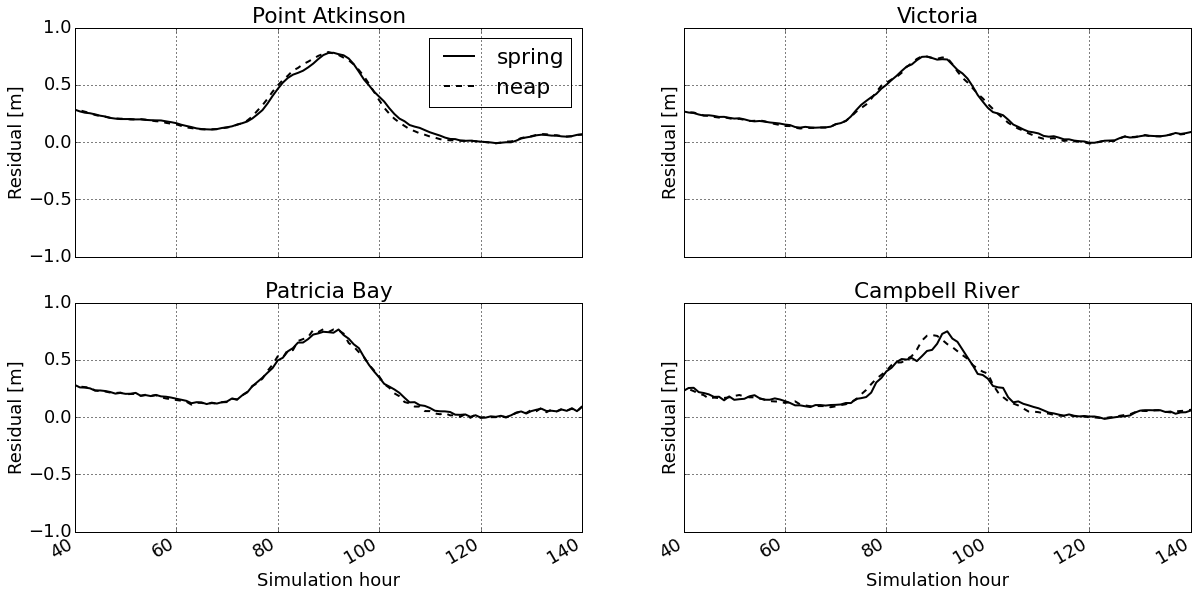

In [58]:
fig,axs= plt.subplots(2,2,figsize=(20,10),sharey=True)
font = {'size'   : 18}

pylab.rc('font', **font)

sts = ['PointAtkinson','Victoria','PatriciaBay', 'CampbellRiver']
proper = ['Point Atkinson','Victoria','Patricia Bay', 'Campbell River']

sim='spring'
print sim
for location, title,ax in zip(sts,proper,axs.flat):
     compare_surge(sshs[sim],ts[sim],sshs['spring_tides'],location,sim,title,ax,style='k-')
sim='neap'
print sim
for location, title, ax in zip(sts,proper,axs.flat):
     compare_surge(sshs[sim],ts[sim],sshs['neap_tides'],location,sim,title,ax,style='k--')
axs[0,0].legend(loc=0)

In [59]:
fig.savefig('spring_neap_res.png',bbox_inches='tight')

Tides

In [62]:
from salishsea_tools.nowcast import figures, analyze

In [84]:
import sys
sys.path.append('/data/nsoontie/MEOPAR/storm-surge/')
import stormtools_revisions

start='31-Dec-2005'; end='02-Jan-2007'
wlev_meas={}; ttide={}; 

msl=stormtools_revisions.MSLS

for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/storm-surge/Revisions/tides/analysis/'+location+'_t_tide_compare8_' +start+'_'+end+'_snr2_filter.csv'
    [ttide[key], _] = stormtools_revisions.load_tidal_predictions(filename)

In [85]:

def plot_tides(sim,ax,style):
    #indec of start and end time
    iss=41
    iee=141
    
    ds = ts[sim][iss]
    de = ts[sim][iee]
    
    ttrun,ts_trun=analyze.truncate_data(np.array(ttide[key].pred_all),np.array(ttide[key].time), ds, de)
    
    ax.plot(np.arange(iss-1,iee-1),ttrun,style,lw=1.5)
    ax.set_ylim([-3,3])
    ax.grid()
    ax.set_ylabel('Water level [m]')
    ax.set_title(sim)
    ax.set_xlabel('Simulation hour')

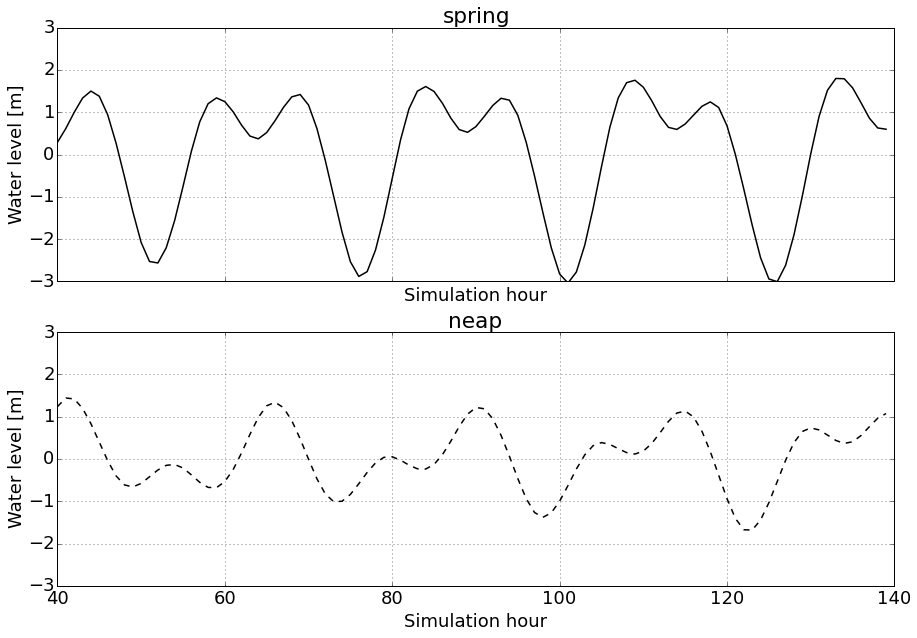

In [88]:
fig,axs=plt.subplots(2,1,figsize=(15,10),sharex=True)

key='PointAtkinson'
plot_tides('spring',axs[0],'k')
plot_tides('neap',axs[1],'k--')

In [89]:
fig.savefig('spring_neap_tides.png',bbox_inches='tight')

In [94]:
def compare_waterlevel(ssh,t_model,location,sim, title,ax,style):
    import matplotlib.dates as mdates
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    fig.autofmt_xdate()
    surge = ssh[location][:,0,0]
    ax.plot(surge, style,  label=sim,lw=2)
    ax.set_ylim([-3,3])
    ax.grid(True,lw=1)
    ax.set_title(title)
    ax.set_xlim([40,140])
    ax.set_ylabel('Water level [m]')
    ax.set_xlabel('Simulation hour')
    m = surge.max();
    tm = surge.argmax()
    print location,surge.max(), tm


spring
PointAtkinson 2.12516 85
Victoria 1.81263 91
PatriciaBay 1.67402 93
CampbellRiver 1.94995 95
neap
PointAtkinson 2.07802 92
Victoria 1.44728 89
PatriciaBay 1.72477 91
CampbellRiver 1.89586 91


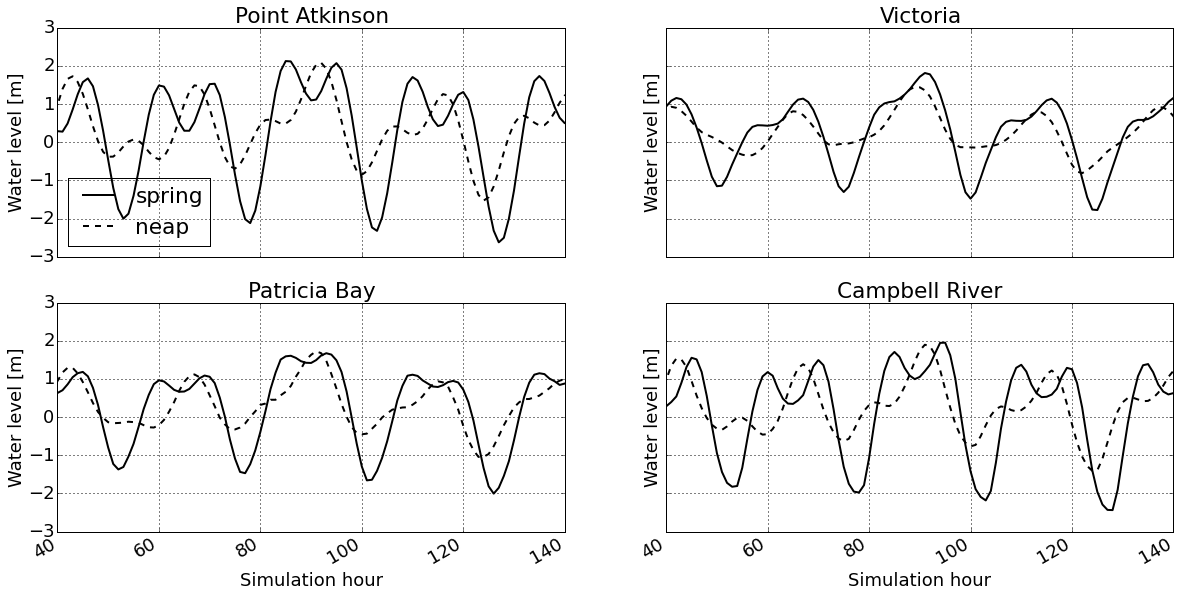

In [95]:
fig,axs= plt.subplots(2,2,figsize=(20,10),sharey=True)
font = {'size'   : 18}

pylab.rc('font', **font)

sts = ['PointAtkinson','Victoria','PatriciaBay', 'CampbellRiver']
proper = ['Point Atkinson','Victoria','Patricia Bay', 'Campbell River']

sim='spring'
print sim
for location, title,ax in zip(sts,proper,axs.flat):
     compare_waterlevel(sshs[sim],ts[sim],location,sim,title,ax,style='k-')
sim='neap'
print sim
for location, title, ax in zip(sts,proper,axs.flat):
     compare_waterlevel(sshs[sim],ts[sim],location,sim,title,ax,style='k--')
axs[0,0].legend(loc=0)